<a href="https://colab.research.google.com/github/momova97/ALY6110/blob/main/Module_4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 4 Assignment
==================
By Mohammad Hossein Movahedi

Introduction
================
For this assignment, I will explore the housing markets through looking at Annual House Price Indexes in Five-Digit and Three-Digit zip codes. I will use the readily available and powerful PySpark tools on Google Colab to sort out the data and  reveal trends. Specifically, using data sourced from the government can give me an insight into how other things influence house prices, such as changing inflation trends and general economic upheavals, among others. I intend to use the data to reveal various facts which show what’s going on with the real estate sector so that you can gain clarity.

# Analysis and Results
For this assignment I'm going to follow these steps:
1 - Import the required libraries
2 - Import the data
3 - Clean the data
4 - Explore the data
5 - Visualize the data

## 1 - Import the required libraries
----

In [5]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=73b584cd042bddc2365d3fa36fc71a6da66d4ad3683b8ee6c880b7153252bf83
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## 2 - Import the data
----

In [37]:
df3digit = spark.read.csv('/content/Three_Digit_ZIP_Codes.csv', header=True, inferSchema=True)
df5digit = spark.read.csv('/content/Five_Digit_ZIP_Codes.csv', header=True, inferSchema=True)

In [38]:
# show headers
print(df5digit.printSchema())

root
 |-- Five-Digit ZIP Code: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Annual Change (%): string (nullable = true)
 |-- HPI: string (nullable = true)
 |-- HPI with 1990 base: string (nullable = true)
 |-- HPI with 2000 base: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)

None


In [39]:
#show avarage annual change
print(df5digit.describe())


DataFrame[summary: string, Five-Digit ZIP Code: string, Year: string, Annual Change (%): string, HPI: string, HPI with 1990 base: string, HPI with 2000 base: string, _c6: string, _c7: string]


## 3 - Clean the data
----


In [40]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

def handle_outliers(dataframe, column_name, multiplier=2):
    """
    Handle outliers by replacing them with the median value if they exceed a certain threshold.

    :param dataframe: The PySpark DataFrame to process
    :param column_name: The name of the column to check for outliers
    :param multiplier: The multiplier to apply to the median value to determine the outlier threshold
    :return: The DataFrame with outliers handled
    """
    # Convert the column to a numeric type (double)
    dataframe = dataframe.withColumn(column_name, col(column_name).cast(DoubleType()))

    # Calculate the median value of the specified column
    median_value = dataframe.approxQuantile(column_name, [0.5], 0.25)[0]

    # Define the outlier threshold
    outlier_threshold = median_value * multiplier

    # Replace outliers with the median value
    dataframe = dataframe.withColumn(column_name,
                                     when(col(column_name) > outlier_threshold, median_value)
                                     .otherwise(col(column_name)))
    return dataframe


In [41]:
df3digit = handle_outliers(df3digit, 'Annual Change (%)')
df5digit = handle_outliers(df5digit, 'Annual Change (%)')

## 4 - Explore the data
----

In [49]:
from pyspark.sql.functions import count, countDistinct
from pyspark.sql.functions import isnan, col

df = df3digit

# Show the schema of the DataFrame to understand the structure of the data
print( 'Schema of the DataFrame: ')
df.printSchema()

# Display the first few rows of the DataFrame to get a sense of the data content
print( 'First few rows of the DataFrame: ')
df.show(5)

# Get a summary of the numerical columns in the DataFrame
print( 'Summary of the numerical columns: ')
df.describe().show()

# Count the number of missing or null values in each column
print( 'Number of missing or null values in each column: ')
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Find the number of distinct values in each column to understand the diversity of the data
print( 'Number of distinct values in each column: ')
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

# Check for duplicate rows
print("Number of duplicate rows: ", df.count() - df.distinct().count())

# Check the distribution of a specific column, for example, 'Annual Change (%)'
df.groupBy('Annual Change (%)').count().orderBy('count', ascending=False).show()

# If the column 'Annual Change (%)' is of string type, convert it to a numeric type to perform further analysis
print('converting column Annual Change (%) to numeric type')
df = df.withColumn('Annual Change (%)', col('Annual Change (%)').cast('double'))

# After conversion, you can now check the distribution of 'Annual Change (%)'
print('Distribution of Annual Change (%) after conversion')
df.groupBy('Annual Change (%)').count().orderBy('count', ascending=False).show()

Schema of the DataFrame: 
root
 |-- Three-Digit ZIP Code: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Annual Change (%): double (nullable = true)
 |-- HPI: string (nullable = true)
 |-- HPI with 1990 base: string (nullable = true)
 |-- HPI with 2000 base: string (nullable = true)
 |-- _c6: string (nullable = true)

First few rows of the DataFrame: 
+--------------------+----+-----------------+------+------------------+------------------+----+
|Three-Digit ZIP Code|Year|Annual Change (%)|   HPI|HPI with 1990 base|HPI with 2000 base| _c6|
+--------------------+----+-----------------+------+------------------+------------------+----+
|                  10|1975|             NULL|100.00|             23.16|             21.64|NULL|
|                  10|1976|             0.87|107.43|             24.88|             23.25|NULL|
|                  10|1977|             0.87|114.95|             26.62|             24.87|NULL|
|                  10|1978|             0.87|123.

I got the  structure of the dataset  from the DataFrame schema, which shows that the dataset includes integer and string types such as zip codes, years, annual change percentage, and different HPI baselines. Some missing values, especially in the ‘Annual Change (%),’ are shown in the first rows. There are outliers. The summary statistics demonstrate considerable variations in age and changes per annum. It ensured data uniqueness as there were no duplicate rows. The conversion of the ‘Annual Change (%)’ column into numeric type was done for detailed distribution and revealed similar annual changes rate of 0.87% for multiple entries.

## 5 - Visualize the data
----


In [50]:
!pip install matplotlib seaborn

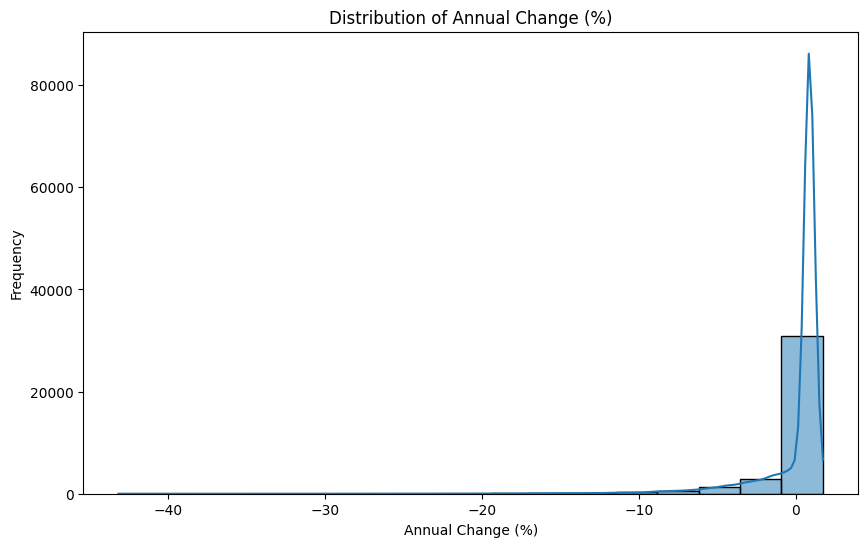

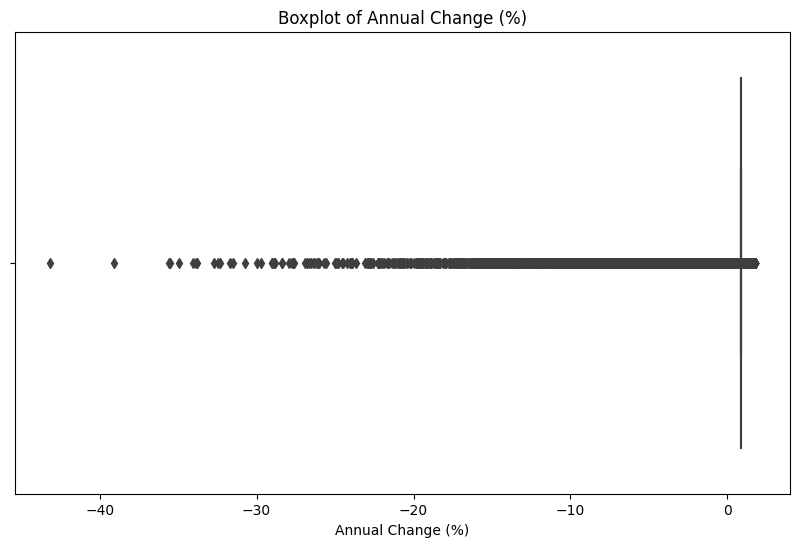

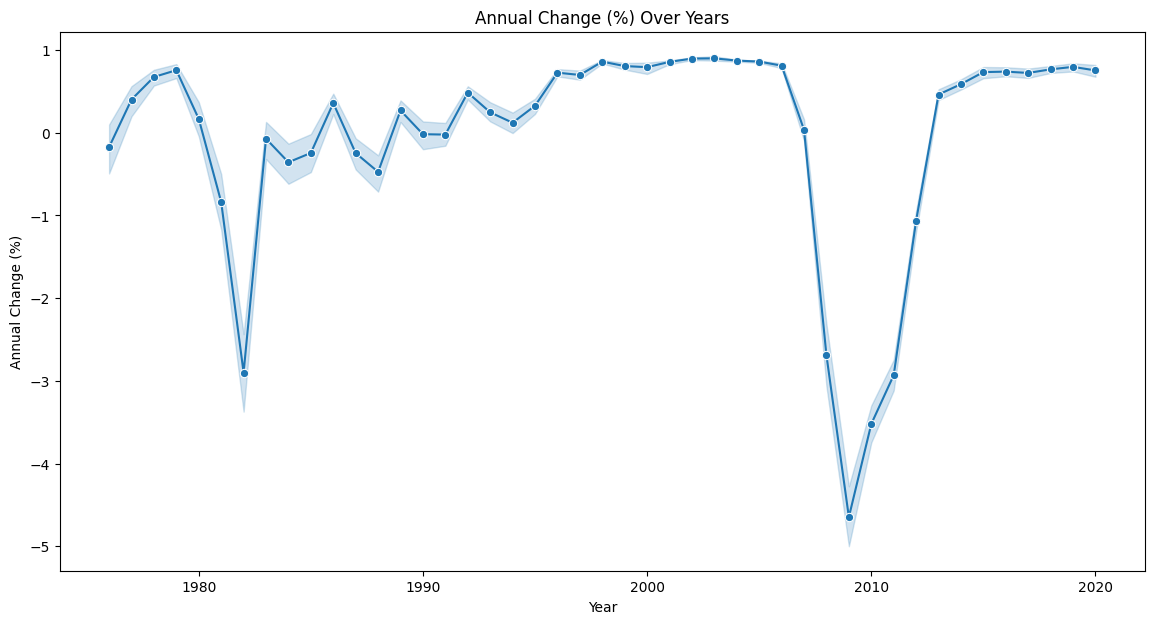

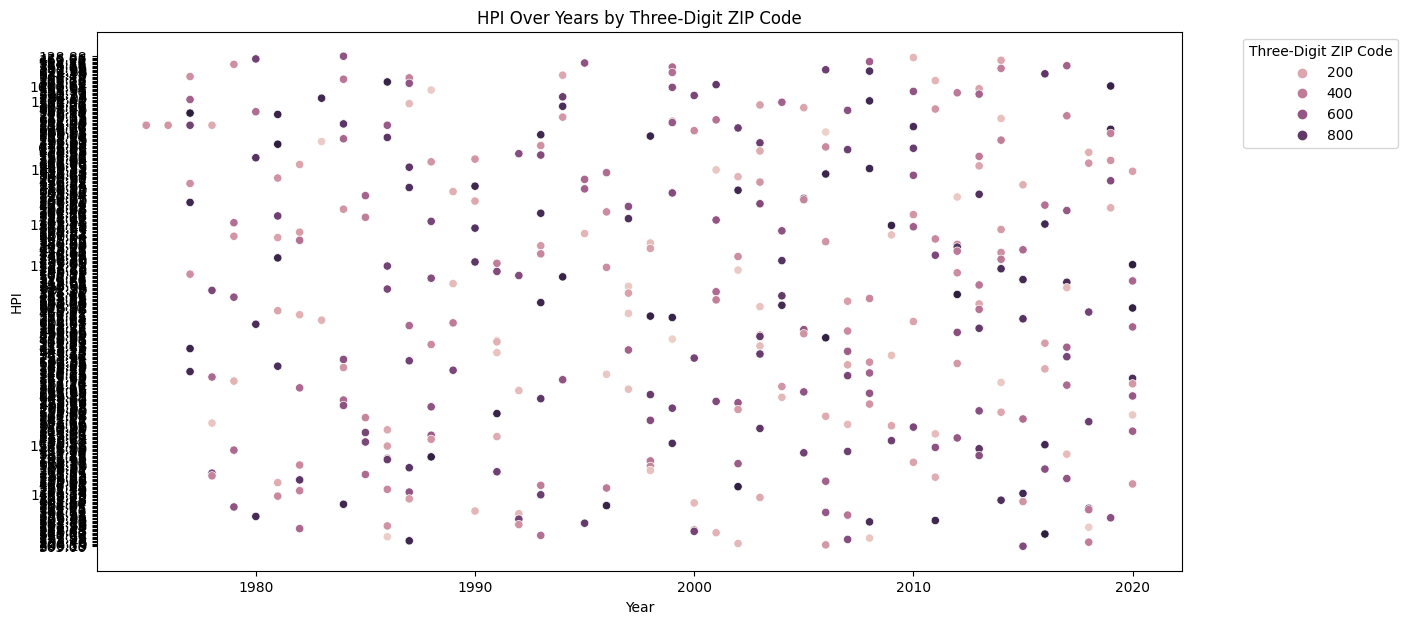

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Histogram of the 'Annual Change (%)' column
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Annual Change (%)'].dropna(), kde=True)
plt.title('Distribution of Annual Change (%)')
plt.xlabel('Annual Change (%)')
plt.ylabel('Frequency')
plt.show()

# Boxplot to check for outliers in 'Annual Change (%)'
plt.figure(figsize=(10, 6))
sns.boxplot(x=pandas_df['Annual Change (%)'])
plt.title('Boxplot of Annual Change (%)')
plt.xlabel('Annual Change (%)')
plt.show()

# Line plot for 'Annual Change (%)' over 'Year'
plt.figure(figsize=(14, 7))
sns.lineplot(data=pandas_df, x='Year', y='Annual Change (%)', marker='o')
plt.title('Annual Change (%) Over Years')
plt.xlabel('Year')
plt.ylabel('Annual Change (%)')
plt.show()

# Scatter plot to visualize the relationship between 'Year' and 'HPI'
#sample the data to reduce the size of the plot
pandas_df = pandas_df.sample(frac=0.01)
plt.figure(figsize=(14, 7))
sns.scatterplot(data=pandas_df, x='Year', y='HPI', hue='Three-Digit ZIP Code')
plt.title('HPI Over Years by Three-Digit ZIP Code')
plt.xlabel('Year')
plt.ylabel('HPI')
plt.legend(title='Three-Digit ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Insights
----


In analyzing the housing market data, I noticed quite a few null spots where information should have been, but I pressed on with the analysis. Interestingly, the annual change in housing prices took a significant dip around the 1980s and then again in 2008, which lines up with times when the U.S. economy was falling. After cleaning up the data, I saw that the numbers were leaning a lot towards zero and even dipping into the negatives, showing that house prices aren't always going up.

Also, when I looked at the scatter plot showing the House Price Index (HPI) over the years, it didn't seem like there was a clear pattern. This tells me that the HPI by itself might not tell us much about how house prices change over time, and we might need to look at other factors for a better idea of how house prices change over time.

# References
----
